# lightcurve repository
<code>https://github.com/swagner-astro/lightcurves</code> <br>

An Illustration for
1. initializing a light curve
2. studying Bayesian blocks
3. characterizing flares (HOP baseline, half, flip, sharp, comparison)
4. initializing a single flare/HOP group
5. working with a set of light curves
    



In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10,3)

from LC import LightCurve
from HOP import Hopject
from LC_Set import LC_Set

## 1. Initialize and plot light curve

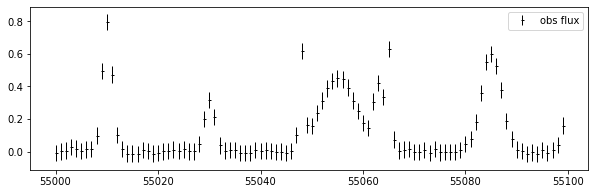

In [2]:
time, flux, flux_error = np.load('./lc.npy') #mock lc with gaussian flares
time += 55000 #e.g. MJD
lc = LightCurve(time, flux, flux_error)
lc.plot_lc()
plt.legend()

## 2. Get and plot Bayesian blocks

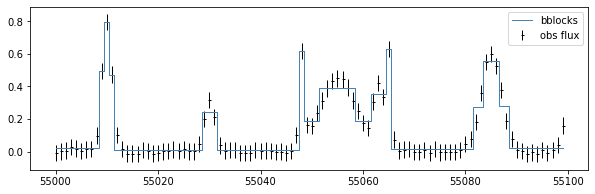

In [3]:
block_pbin, block_val, block_val_error, edge_index, edges = lc.get_bblocks(p0_value=0.05)
#for more information on edges and edge_index see Appendix A2
lc.plot_bblocks()
plt.legend()

## 3. Characterize flares as group of blocks

### 3.1. HOP baseline

HOP: [start, peak, end]
[[55008.5 55010.  55011.5]
 [55028.5 55030.  55031.5]
 [55047.5 55065.  55065.5]
 [55081.5 55085.  55088.5]]


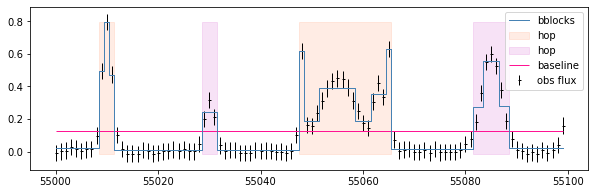

In [4]:
hops_bl = lc.get_hop_baseline() 
print('HOP: [start, peak, end]')
print(hops_bl)
lc.plot_hop('baseline')
lc.plot_bblocks()
plt.legend()

### 3.2. HOP half

HOP: [start, peak, end]
[[55000.  55010.  55020. ]
 [55020.  55030.  55039.5]
 [55039.5 55048.  55050. ]
 [55050.  55055.  55060. ]
 [55060.  55065.  55073.5]
 [55073.5 55085.  55099. ]]


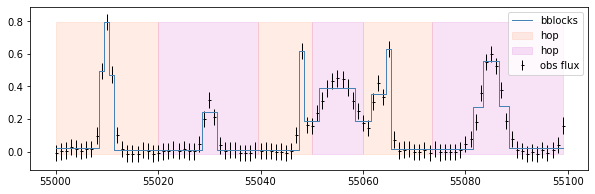

In [5]:
hops_half = lc.get_hop_half(lc_edges='add') 
print('HOP: [start, peak, end]')
print(hops_half)
lc.plot_hop('half')
lc.plot_bblocks()
plt.legend()

### 3.3. HOP flip

HOP: [start, peak, end]
[[55025.5 55030.  55034.5]
 [55046.5 55048.  55049.5]
 [55050.  55055.  55060. ]
 [55060.  55065.  55066.5]]


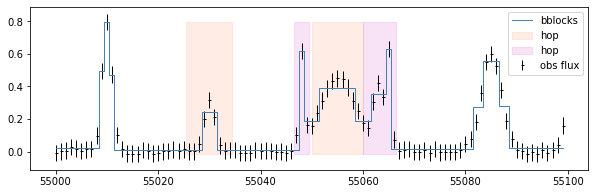

In [6]:
hops_flip = lc.get_hop_flip(lc_edges='neglect') 
print('HOP: [start, peak, end]')
print(hops_flip)
lc.plot_hop('flip')
lc.plot_bblocks()
plt.legend()

### 3.4. HOP sharp

HOP: [start, peak, end]
[[55000.  55010.  55011.5]
 [55028.5 55030.  55031.5]
 [55047.5 55048.  55048.5]
 [55051.5 55055.  55058.5]
 [55061.5 55065.  55065.5]
 [55081.5 55085.  55099. ]]


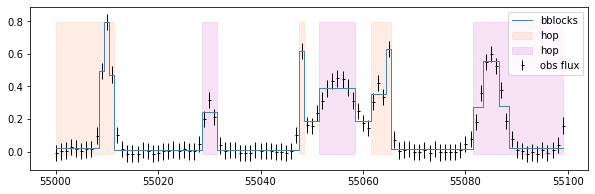

In [7]:
hops_sharp = lc.get_hop_sharp(lc_edges='add') 
print('HOP: [start, peak, end]')
print(hops_sharp)
lc.plot_hop('sharp')
lc.plot_bblocks()
plt.legend()

### Comparison

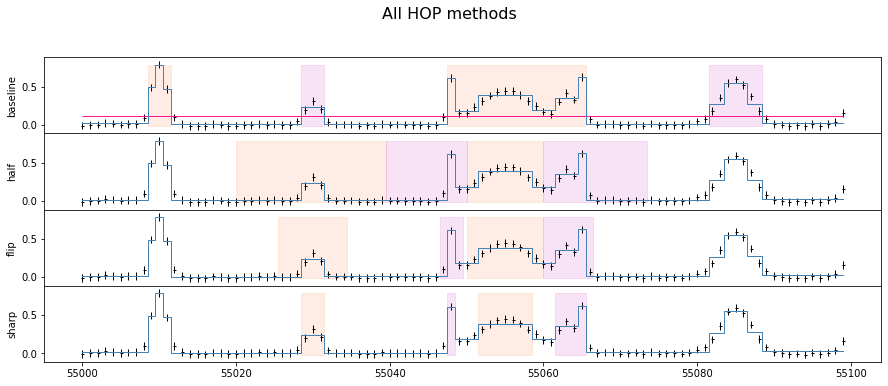

In [8]:
lc.plot_all_hop(lc_edges='neglect')

## 4. Properties of individual flares

asymmetry measure:  0.0


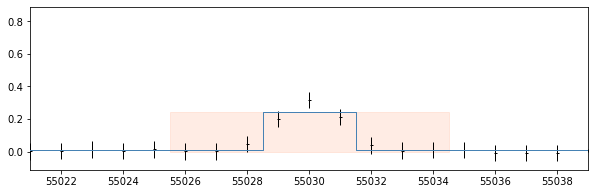

In [9]:
hop = Hopject(hops_flip[0], lc)
print('asymmetry measure: ', hop.asym)
hop.plot_hop()

## 5. Distribution of flare properties in sample of light curves

### 5.1. Create mock light curves 
Create 10 light curves with 60 Gaussian flares at random position of 2000 bins. This is neither part of the repository nor useful physics but included for illustrative purposes.

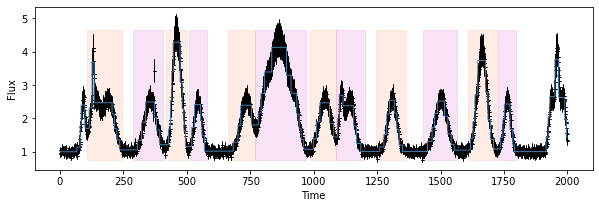

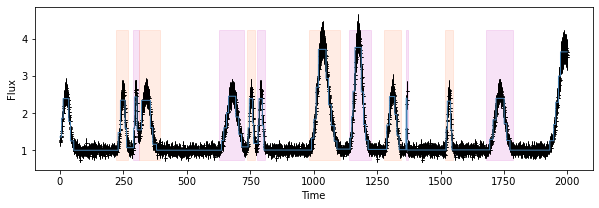

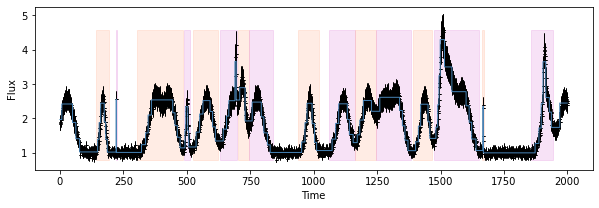

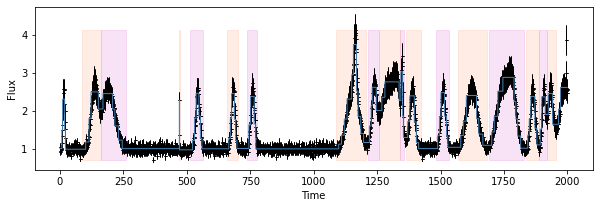

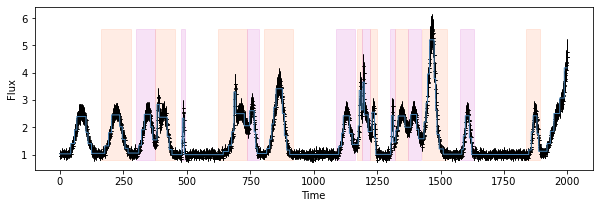

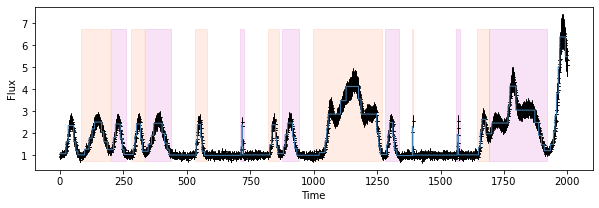

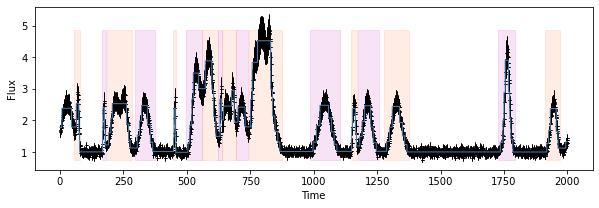

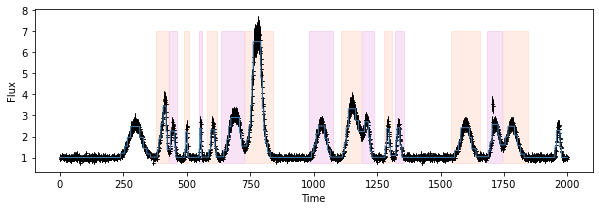

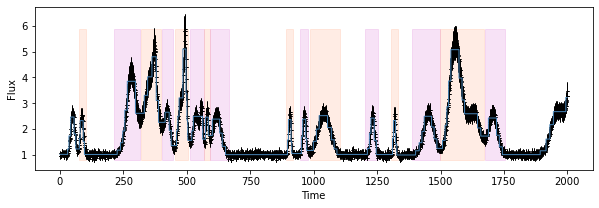

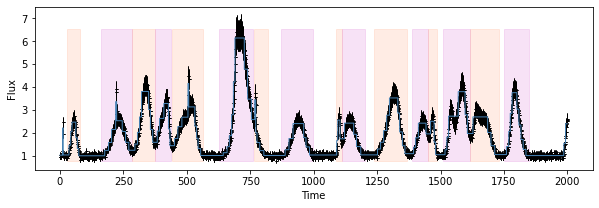

In [62]:
time = np.arange(0, 2000, 1)        # e.g. daily binning for 12 years = 4380 days of observation
N_b=len(time)         # number of bins
flux = np.ones(N_b)
rel_flux_error = 0.1       # flux error ~ 5% 
noise = np.random.normal(0, 0.07, N_b)        # white noise backround with strength 

# maximum values for gaussian flares
amp_max = 100
cen_max = 4380
wid_max = 40

def gaussian(x, amp, cen, wid):
    "1-d Gaussian: gaussian(x=data, amp, cen, wid)"
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

def rand_gauss(x, amp_max, cen_max, wid_max):
    "random 1-d Gaussian"
    "takes maximum values for parameters and multiplies each with uniform random number [0,1) ... 0 aba kee1"
    "https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html"
    amp = np.random.random(1) * amp_max
    cen = np.random.random(1) * cen_max
    #wid = np.random.random(1) * wid_max
    wid = amp*0.25       # assume that flares are self similar; always same shape
    return(gaussian(x, amp, cen, wid))

lc_array = np.zeros(10, dtype=object)
for l in range(10):
    flux = np.ones(N_b)
    for f in range(60):
        flare = rand_gauss(time, amp_max, cen_max, wid_max)
        flux += flare
    flux += noise
    flux_error = flux * rel_flux_error
    lc = LightCurve(time, flux, flux_error)
    lc.get_bblocks()
    lc.get_hop_flip()
    lc_array[l] = lc
    
    plt.figure(l)
    lc.plot_lc()
    lc.plot_bblocks()
    lc.plot_hop('flip')
    plt.xlabel('Time')
    plt.ylabel('Flux')

### 5.2. Create LC_Set

Text(0.5, 0, 'asymmetry measure')

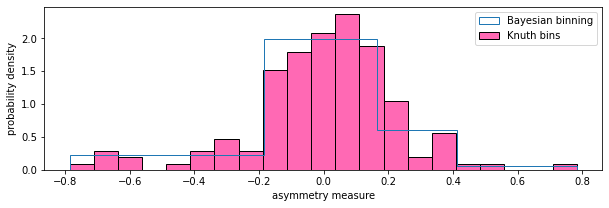

In [65]:
lcs = LC_Set(lc_array, block_min = 2)       #single block flares do not resolve asymmetry
lcs.plot_asym()
plt.legend()
plt.ylabel('probability density')
plt.xlabel('asymmetry measure')
# for histogram binning see https://docs.astropy.org/en/stable/api/astropy.visualization.hist.html

# APPENDIX

### A1: Find significant fluctuations with respect to threshold
1. <code>flux_buffer</code><br>
Set every flux bin under threshold to threshold before initializing light curve object and then apply Bayesian blocks 

2. <code>get_bblocks_above</code><br>
Create Bayesian blocks for light curve but set every block that is under threshold to threshold

-> detect significant variations wrt threshold = flares?

ATTENTION! This returns artificial flux values! Use cautiously if at all..

### A2: <code>astropy.stats.bayesian_blocks</code> returns edges 
i.e. value in unit of time where changes are significant; first and last edge coincide with data bin, the rest is inbetween data bins (shown with red stripes)<br>
what we need for further processing is index of time array (shown with green stripes)

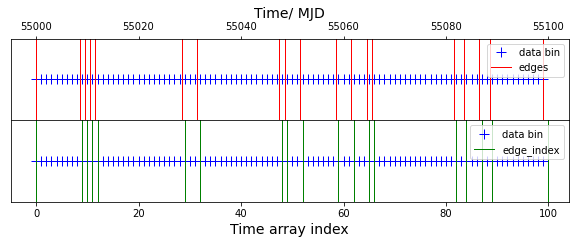

In [12]:
time, flux, flux_error = np.load('./lc.npy') #mock lc with gaussian flares
time += 55000 #e.g. MJD
fig = plt.figure(0,(10,3))
time_one = np.ones(len(time)) #used for plotting
ax0 = fig.add_subplot(211)
plt.plot(time,time_one,linewidth=0,label='data bin',marker='+',c = 'blue', markersize=10)
plt.axvline(edges[0],color='red',label='edges',linewidth=1)
for i in range(1,len(edges)):
    plt.axvline(edges[i],color='red',linewidth=1)
plt.xlabel('Time/ MJD', fontsize = 14)
plt.yticks([])
ax0.xaxis.tick_top()
ax0.xaxis.set_label_position('top') 
plt.legend()

ax1 = fig.add_subplot(212)
plt.plot(time_one,linewidth=0,label='data bin',marker='+',c = 'blue', markersize=10)
plt.axvline(edge_index[0],color='green',label='edge_index',linewidth=1)
for i in range(1,len(edge_index)):
    plt.axvline(edge_index[i],color='green',linewidth=1)
plt.xlabel('Time array index', fontsize = 14)
plt.yticks([])
plt.legend()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0)